# Split Window Difference (11.2-10.3um BTD) visualized

### Data is accessed from Amazon Web Solutions.

In [1]:
#---Cloud search libraries
import s3fs
import requests
import fnmatch

#---Data libraries
import xarray as xr
import netCDF4
import numpy as np
import datetime

#---Plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

**Hooking up the AWS S3 buckets:**

In [2]:
fs = s3fs.S3FileSystem(anon=True)

**Set the datetime range of interest:**

In [3]:
year = 2024
month = 2
month_name = 'Feb'
day_start = 8
day_end = 8
hour = 7

**Getting GOES-16 radiance data:**

In [4]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadF'

**Gathering a month of top-of-the-hour data from ABI band 13 and band 14:**

In [5]:
range(day_end-(day_start-1))

range(0, 1)

In [6]:
b13_data = []
b14_data = []
day = day_start

for i in range(day_end-(day_start-1)):
    julian = datetime.datetime(year, month, day).strftime('%j')
    data_path = bucket + '/' + product + '/'  + str(year) + '/' + str(julian).zfill(3) + '/' + str(hour).zfill(2)
    files = fs.ls(data_path)
    
    files_b13 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C13".zfill(2)+"*")]
    files_b14 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C14".zfill(2)+"*")]

    #---index of 0 to get top-of-the-hour
    b13_data.append(files_b13[0])
    b14_data.append(files_b14[0])

    day = day+1

In [7]:
b13_data

['noaa-goes16/ABI-L1b-RadF/2024/039/07/OR_ABI-L1b-RadF-M6C13_G16_s20240390700206_e20240390709525_c20240390709576.nc']

**Functions for calculating geostationary lat/lon:**

In [8]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

**Setting the lat/lon range of the imagery:**

In [9]:
#--- Georges Bank
# min_lon = -71.5
# min_lat = 37
# max_lon = -64
# max_lat = 42.5

#---Gulf Stream
# min_lon = -77
# min_lat = 33
# max_lon = -50
# max_lat = 45

#--- Oaxaca
min_lon = -109
min_lat = 10
max_lon = -81
max_lat = 24

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

**Function for creating the 11.2um - 10.3um BTD:**

In [10]:
def create_BTD(data_1, data_2, filename):

    year = filename[27:31]
    jul_day = filename[31:34]
    h = filename[34:36]
    m = filename[36:38]

    print('Processing first band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_1 = calc_latlon(data_1)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_1, lats, lons)

    subset_1 = ds_1.sel(x=slice(x1, x2), y=slice(y2, y1))

    print('Processing second band for '+year+'-'+jul_day+' '+h+':'+m)

    ds_2 = calc_latlon(data_2)

    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_2, lats, lons)

    subset_2 = ds_2.sel(x=slice(x1, x2), y=slice(y2, y1))

    #--- Calculate BTD and take product of the data over time
    T_1 = (subset_1.planck_fk2/(np.log((subset_1.planck_fk1/subset_1.Rad)+1)) - subset_1.planck_bc1)/subset_1.planck_bc2
    T_2 = (subset_2.planck_fk2/(np.log((subset_2.planck_fk1/subset_2.Rad)+1)) - subset_2.planck_bc1)/subset_2.planck_bc2

    BTD = T_1 - T_2
    
    yr_m_d = datetime.datetime.strptime(year+jul_day, '%Y%j').date()
    time_delta = datetime.timedelta(hours=int(h), minutes=int(m))
    dt = datetime.datetime.combine(yr_m_d, datetime.datetime.min.time()) + time_delta
    BTD = BTD.expand_dims({'time':[dt]})
    
    return BTD

**Single day: Choose date from list, accessing from AWS, then processing to create the BTD:**

In [11]:
date_index = 0

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b13_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b13 file not found in AWS servers')

nc_13 = netCDF4.Dataset(b13_data[date_index], memory = resp.content)
ds_13 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_13))

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b14_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b14 file not found in AWS servers')

nc_14 = netCDF4.Dataset(b14_data[date_index], memory = resp.content)
ds_14 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_14))

filename = b13_data[date_index].split('/')[-1]

In [12]:
BTD = create_BTD(ds_14, ds_13, filename)

Processing first band for 2024-039 07:00
Processing second band for 2024-039 07:00


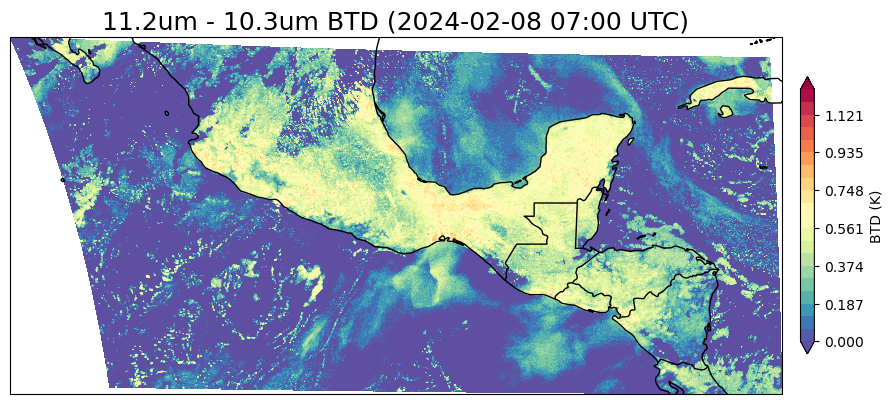

In [13]:
dt = BTD.time.values[0]
date_str = np.datetime_as_string(dt)[:10]
time_str = np.datetime_as_string(dt)[11:16]


projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, np.max(BTD), 21)

c=ax.contourf(BTD.lon, BTD.lat, BTD[0], cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('11.2um - 10.3um BTD ('+date_str +' '+time_str+' UTC)', fontsize=18)
clb.set_label('BTD (K)')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#plt.savefig("sample_images/swd_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')

## Making the corrected low cloud field:
* Subtracting the 11.2-10.3 from the 11.2-3.9 BTD
* Theoretically removing the false low clouds
* Needs the above cells to have been run

**Creating the brightness temperature difference for 11.2-3.9:**

In [14]:
SWD = BTD

In [15]:
b07_data = []
day = day_start

for i in range(day_end-(day_start-1)):
    julian = datetime.datetime(year, month, day).strftime('%j')
    data_path = bucket + '/' + product + '/'  + str(year) + '/' + str(julian).zfill(3) + '/' + str(hour).zfill(2)
    files = fs.ls(data_path)
    
    files_b07 = [file for file in files if fnmatch.fnmatchcase(file.split('/')[-1], "OR_ABI-L1b-RadF-M6C07".zfill(2)+"*")]

    #---index of 0 to get top-of-the-hour
    b07_data.append(files_b07[0])

    day = day+1

In [16]:
b07_data

['noaa-goes16/ABI-L1b-RadF/2024/039/07/OR_ABI-L1b-RadF-M6C07_G16_s20240390700206_e20240390709525_c20240390709567.nc']

In [17]:
date_index = 0

resp = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+b07_data[date_index][12:])
if str(resp) != '<Response [200]>':
    print('b07 file not found in AWS servers')

nc_07 = netCDF4.Dataset(b07_data[date_index], memory = resp.content)
ds_07 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_07))

filename = b07_data[date_index].split('/')[-1]

In [18]:
NLCT = create_BTD(ds_14, ds_07, filename)

Processing first band for 2024-039 07:00
Processing second band for 2024-039 07:00


**Removing the negative brightness temperature differences:**

In [19]:
SWD = xr.where(SWD < 0, 0, SWD)
NLCT = xr.where(NLCT < 0, 0, NLCT)

In [20]:
np.max(NLCT)

<xarray.DataArray ()>
array(6.55004883)
Coordinates:
    y_image  float32 0.0
    x_image  float32 0.0

In [21]:
np.max(SWD)

<xarray.DataArray ()>
array(1.2460022)
Coordinates:
    y_image  float32 0.0
    x_image  float32 0.0

**Scaling the 11.2-10.3 and the 11.2-3.9 to be within the same range:**

In [22]:
SWD_scaled = SWD/np.max(SWD)
NLCT_scaled = NLCT/np.max(NLCT)

**Subtracting the SWD from the NLCT:**

In [23]:
LowCloudField = NLCT_scaled - SWD_scaled

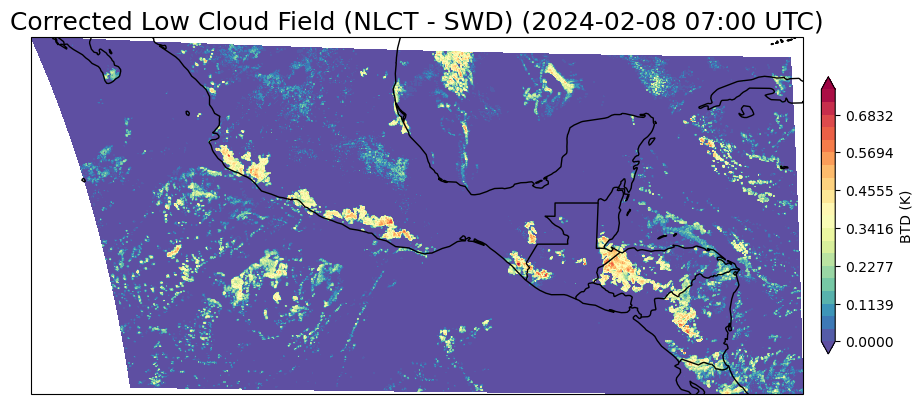

In [24]:
dt = LowCloudField.time.values[0]
date_str = np.datetime_as_string(dt)[:10]
time_str = np.datetime_as_string(dt)[11:16]


projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(0, np.max(LowCloudField), 21)

c=ax.contourf(LowCloudField.lon, LowCloudField.lat, LowCloudField[0], cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Corrected Low Cloud Field (NLCT - SWD) ('+date_str +' '+time_str+' UTC)', fontsize=18)
clb.set_label('BTD (K)')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#plt.savefig("sample_images/lowcloudfield_"+date_str[0:4]+date_str[5:7]+date_str[8:10]+"_"+time_str[0:2], bbox_inches='tight')